# Import Important Library

In [1]:
import pandas as pd #for read data
import re #for text cleansing

from nltk.corpus import stopwords #for clean stopwords

#visualization
import matplotlib.pyplot as plt
import seaborn as sns 

#save model
import pickle

## Read Data

In [2]:
dfText = pd.read_csv('dataset/train_preprocess_-_BALANCE.tsv', sep='\t', names=['text', 'label'])
dfText.head()

,text,label
0,saya tadinya penasaran dengan tempat ini karen...,negative
1,"kang , jalan di muararajeun baru , baru sebula...",negative
2,melihat itu kader demokrat ribut dengan pak hn...,negative
3,"tak usah nonton film itu , bahasa jawa semua ....",negative
4,"ini si monyet bawah gua , nama nya saja anonim...",negative


In [3]:
dfAlay = pd.read_csv('dataset/new_kamusalay.csv', encoding='latin-1', names=['original', 'replacement'])
dfAlay

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


# Cleansing Text

In [4]:
# remove kata alay
def normalize_alay(text):
    alay_dict_map = dict(zip(dfAlay['original'], dfAlay['replacement']))
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

# remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]',' ',text)

# remove stopword
def remove_stopword(text):
    stopword_list = set(stopwords.words('indonesian'))
    return ' '.join([word for word in text.split(' ') if word not in stopword_list])

In [5]:
def preprocess(text):
    text = normalize_alay(text)
    text = remove_punctuation(text)
    # text = remove_stopword(text)
    return text

In [6]:
dfText['text'] = dfText['text'].apply(preprocess)
dfText['text'] = dfText['text'].str.lower()
dfText

,text,label
0,saya tadinya penasaran dengan tempat ini karen...,negative
1,kang jalan di muararajeun baru baru sebula...,negative
2,melihat itu kader demokrat ribut dengan pak hn...,negative
3,tak usah menonton film itu bahasa jawa semua...,negative
4,ini sih monyet bawah gue nama nya saja anoni...,negative
...,...,...
10195,mereka mempertahankan spesifikasi dasar dari m...,neutral
10196,mereka mempertahankan kejuaraan setelah memen...,neutral
10197,mereka mempertahankan gelar juara pada tahun 2...,neutral
10198,mereka mempertahankan kemerdekaan administrati...,neutral


In [7]:
dictLabel = {'neutral' : 0, 'positive' : 1, 'negative' : 2}
dfText['label'] = dfText['label'].map(dictLabel)
dfText['label']

0        2
1        2
2        2
3        2
4        2
        ..
10195    0
10196    0
10197    0
10198    0
10199    0
Name: label, Length: 10200, dtype: int64

# EDA

## Check Info Data

In [8]:
len(dfText)

10200

In [9]:
dfText.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10200 non-null  object
 1   label   10200 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.5+ KB


In [10]:
dfText.isnull().sum()

text     0
label    0
dtype: int64

# Tf-idf Transformer

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras_preprocessing.sequence import pad_sequences

In [12]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(dfText['text'])
X_train_counts.shape

with open('models/count_vect.pkl', 'wb') as f:
    pickle.dump(count_vect, f)

In [13]:
tf_tranformer =TfidfTransformer(smooth_idf=True,use_idf=True).fit(X_train_counts)
X_train_tf = tf_tranformer.transform(X_train_counts).toarray()
print(X_train_tf.shape)

with open('models/tf_transformer.pkl', 'wb') as f:
    pickle.dump(tf_tranformer, f)

(10200, 19833)


# Tokenization and Change Label to Categorical

In [14]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [15]:
arrayLabel = dfText['label'].to_numpy()

In [16]:
import tensorflow as tf

labels = tf.keras.utils.to_categorical(arrayLabel, 3, dtype="float32")

In [17]:
len(labels)

10200

In [18]:
max_words = 10200
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dfText['text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(dfText['text'])
text = pad_sequences(sequences, maxlen=max_len)
print(text.shape)

with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

(10200, 200)


# Training

In [19]:
from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop,Adam   
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import EarlyStopping

## Split Data

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# split tfidftransformers data
X_train_transf, X_test_transf, y_train_transf, y_test_transf = train_test_split(X_train_tf,labels, random_state=0)
print(len(X_train_transf),len(X_test_transf),len(y_train_transf),len(y_test_transf))

7650 2550 7650 2550


In [22]:
# split tokenization data
X_train_token, X_test_token, y_train_token, y_test_token = train_test_split(text,labels, random_state=0)
print(len(X_train_token),len(X_test_token),len(y_train_token),len(y_test_token))

7650 2550 7650 2550


## LSTM

In [23]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint1 = EarlyStopping(monitor='val_accuracy', verbose=1, mode='auto', patience=3)
history = model1.fit(X_train_token, y_train_token, epochs=70,validation_data=(X_test_token, y_test_token),callbacks=[checkpoint1])
model1.save('models/LSTMmodel.h5')

Epoch 1/70
240/240 [==============================] - 29s 89ms/step - loss: 0.7815 - accuracy: 0.6753 - val_loss: 0.5528 - val_accuracy: 0.8043
Epoch 2/70
240/240 [==============================] - 21s 89ms/step - loss: 0.4222 - accuracy: 0.8480 - val_loss: 0.3520 - val_accuracy: 0.8733
Epoch 3/70
240/240 [==============================] - 19s 80ms/step - loss: 0.2870 - accuracy: 0.8995 - val_loss: 0.3079 - val_accuracy: 0.8925
Epoch 4/70
240/240 [==============================] - 20s 82ms/step - loss: 0.2075 - accuracy: 0.9297 - val_loss: 0.3038 - val_accuracy: 0.8961
Epoch 5/70
240/240 [==============================] - 19s 81ms/step - loss: 0.1594 - accuracy: 0.9486 - val_loss: 0.3044 - val_accuracy: 0.8976
Epoch 6/70
240/240 [==============================] - 20s 82ms/step - loss: 0.1279 - accuracy: 0.9596 - val_loss: 0.3194 - val_accuracy: 0.9012
Epoch 7/70
240/240 [==============================] - 20s 81ms/step - loss: 0.1127 - accuracy: 0.9643 - val_loss: 0.3262 - val_accuracy:

## ANN

In [25]:
from sklearn.neural_network import MLPClassifier
import pickle

clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32), activation="relu",random_state=1, solver='adam', alpha=1e-5, early_stopping=True, max_iter=1000, verbose=True)
clf.fit(X_train_transf,y_train_transf)

pkl_filename = "models/ANNmodel.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file) 

Iteration 1, loss = 1.79666318
Validation score: 0.552941
Iteration 2, loss = 0.74582465
Validation score: 0.856209
Iteration 3, loss = 0.24663216
Validation score: 0.874510
Iteration 4, loss = 0.10623034
Validation score: 0.866667
Iteration 5, loss = 0.06069800
Validation score: 0.874510
Iteration 6, loss = 0.04050808
Validation score: 0.862745
Iteration 7, loss = 0.03014513
Validation score: 0.864052
Iteration 8, loss = 0.02441363
Validation score: 0.869281
Iteration 9, loss = 0.02015301
Validation score: 0.870588
Iteration 10, loss = 0.01514039
Validation score: 0.870588
Iteration 11, loss = 0.01219597
Validation score: 0.873203
Iteration 12, loss = 0.00944236
Validation score: 0.877124
Iteration 13, loss = 0.00699904
Validation score: 0.875817
Iteration 14, loss = 0.00554665
Validation score: 0.874510
Iteration 15, loss = 0.00416062
Validation score: 0.873203
Iteration 16, loss = 0.00355689
Validation score: 0.861438
Iteration 17, loss = 0.00339874
Validation score: 0.879739
Iterat

In [26]:
y_pred=clf.predict(X_test_transf)
y_pred

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

# Validation

In [24]:
import numpy as np
import keras
from sklearn.metrics import confusion_matrix

## LSTM

In [25]:
best_model = keras.models.load_model("models/LSTMmodel.h5")

In [26]:
test_loss, test_acc = best_model.evaluate(X_test_token, y_test_token, verbose=2)
print('Model accuracy: ',test_acc)

80/80 - 2s - loss: 0.3930 - accuracy: 0.8871 - 2s/epoch - 24ms/step
Model accuracy:  0.8870587944984436


In [27]:
predictions = best_model.predict(X_test_token)

80/80 [==============================] - 2s 15ms/step


In [ ]:
matrix = confusion_matrix(y_test_token.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

C:\Users\ansha\AppData\Local\Temp\ipykernel_18548\3444368053.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


<AxesSubplot: >

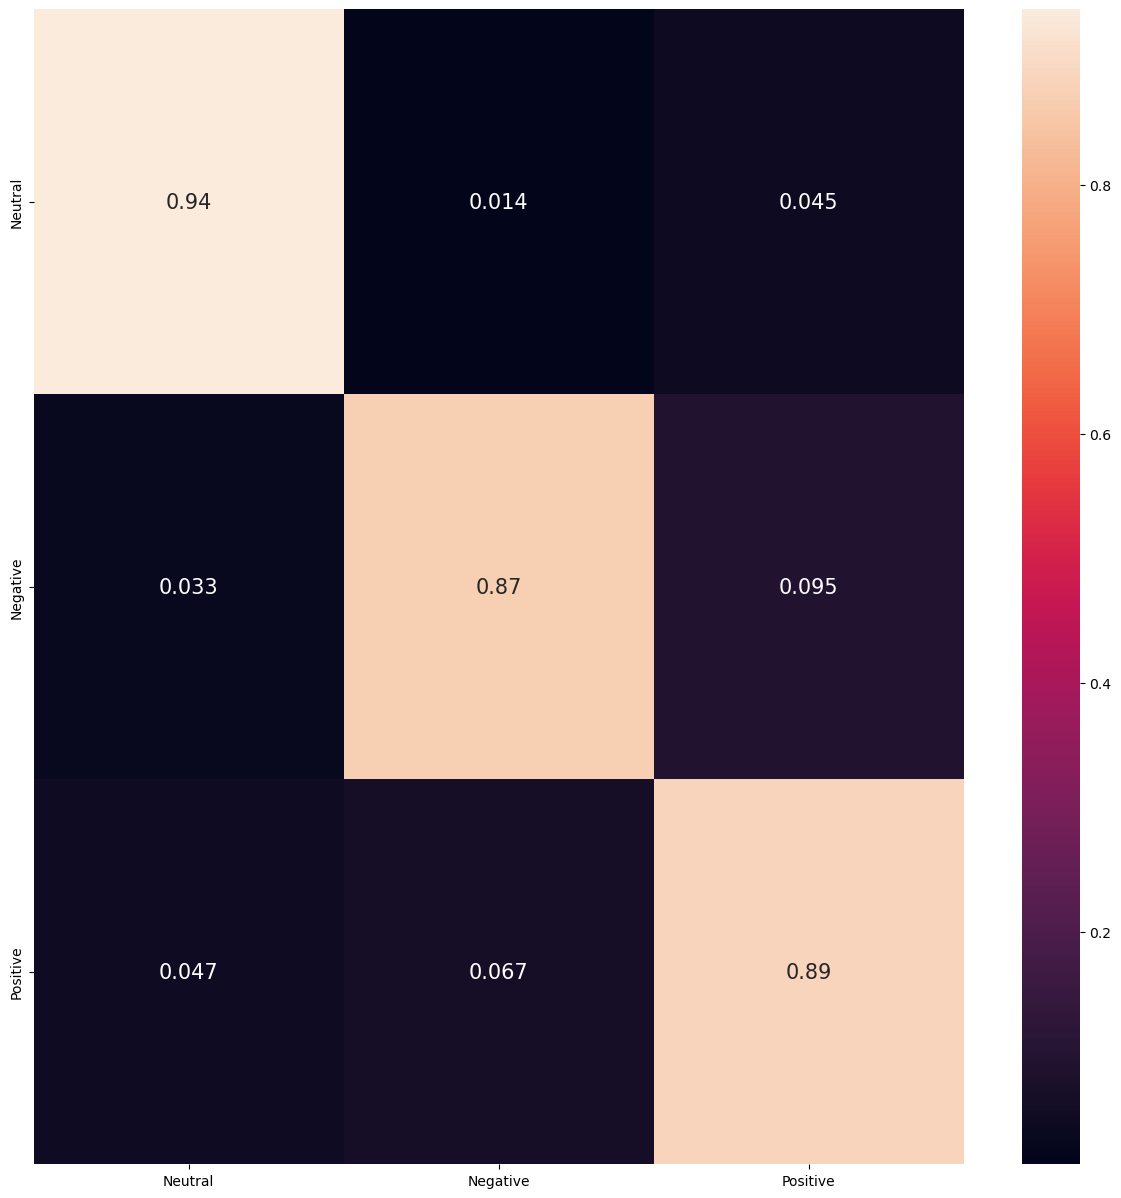

In [ ]:
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [28]:
label = ['neutral', 'positive', 'negative']

In [34]:
sequence = tokenizer.texts_to_sequences(['makanan disini enak enak dan murah banget'])
test = pad_sequences(sequence, maxlen=max_len)
label[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 54ms/step


'positive'

## ANN

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_test_transf, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       881
           1       0.87      0.86      0.87       839
           2       0.84      0.84      0.84       830

   micro avg       0.89      0.87      0.88      2550
   macro avg       0.89      0.87      0.88      2550
weighted avg       0.89      0.87      0.88      2550
 samples avg       0.87      0.87      0.87      2550



c:\Users\ansha\.conda\envs\binar-platinum\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
